<a href="https://colab.research.google.com/github/Pai026/DermaCamModel/blob/main/FacialSkinDiseaseDetectionModelFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf
from keras.layers import Dense
import keras

In [2]:
dataDir = "/content/drive/My Drive/Training"
skinDiseaseTypes= [ item for item in os.listdir(dataDir) if os.path.isdir(os.path.join(dataDir, item)) ]
trainDir = os.path.join(dataDir)

In [3]:
trainData = []
for diseaseID, sp in enumerate(skinDiseaseTypes):
    for file in os.listdir(os.path.join(trainDir, sp)):
        trainData.append(['{}/{}'.format(sp, file), diseaseID, sp])
        
train = pd.DataFrame(trainData, columns=['File', 'DiseaseId','Disease Type'])
train.tail()

,File,DiseaseId,Disease Type
254,blackhead/b67.jpg,6,blackhead
255,blackhead/b59.jpg,6,blackhead
256,blackhead/b70.jpg,6,blackhead
257,blackhead/b62.jfif,6,blackhead
258,blackhead/b65.jpg,6,blackhead


In [4]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) 
train.head()

,File,DiseaseId,Disease Type
0,acne fulminans/f69.JPG,1,acne fulminans
1,acne fulminans/f46.JPG,1,acne fulminans
2,fungal acne/fu59.JPG,0,fungal acne
3,acne nodules/n36.JPG,2,acne nodules
4,rosacea/r73.jpg,3,rosacea


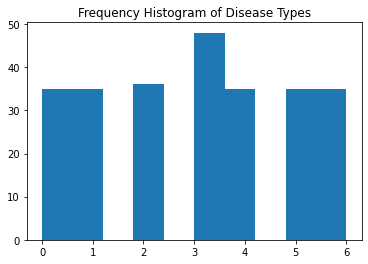

<Figure size 864x864 with 0 Axes>

In [5]:
plt.hist(train['DiseaseId'])
plt.title('Frequency Histogram of Disease Types')
plt.figure(figsize=(12, 12))
plt.show()

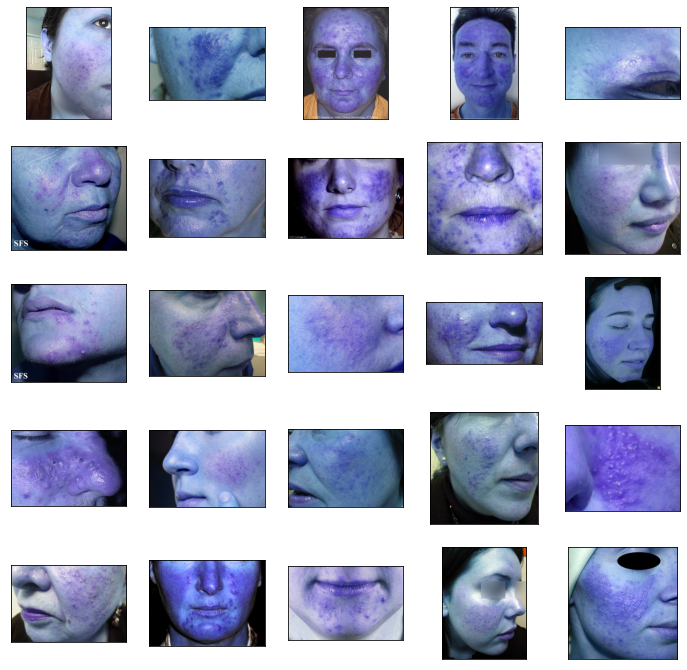

In [7]:
def plot_defects(skinDiseaseTypes, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    flowerFiles = train['File'][train['Disease Type'] == skinDiseaseTypes].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            imagePath = os.path.join(dataDir, flowerFiles[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(imagePath))
            n += 1
# Displays first n images of class from training set
plot_defects('rosacea', 5, 5)

In [8]:
imageSize = 64

def read_image(filePath):
    return cv2.imread(os.path.join(dataDir, filePath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, imageSize):
    return cv2.resize(image.copy(), imageSize, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], imageSize, imageSize, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (imageSize, imageSize))

X_Train = X_train / 255
print('Train Shape: {}'.format(X_Train.shape))

259it [02:52,  1.50it/s]

Train Shape: (259, 64, 64, 3)


In [10]:
Y_train = train['DiseaseId'].values
Y_train = to_categorical(Y_train, num_classes=7)

In [11]:
batchSize = 64

X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)
print(len(X_train))
print(len(Y_train))
print(len(X_val))
print(len(Y_val))

207
207
52
52


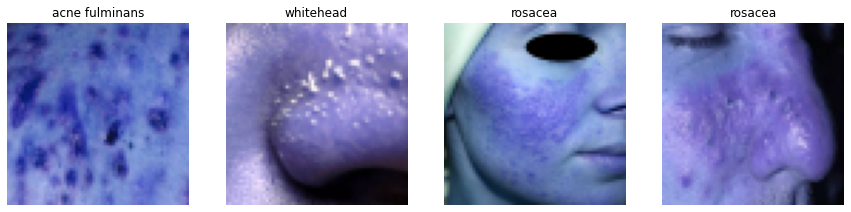

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(skinDiseaseTypes[np.argmax(Y_train[i])])

# Data Augmentation

In [13]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,MaxPooling2D

image_dir = "/content/drive/My Drive/Training"
data_generator = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=30, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest"
                                   )

train_generator = data_generator.flow_from_directory(
        image_dir,
        subset="training",
        target_size=(64,64),
        batch_size=64,
        class_mode='categorical')


validation_generator = data_generator.flow_from_directory(
        image_dir,
        subset="validation",
        target_size=(64,64),
        batch_size=64,
        class_mode='categorical')

Found 183 images belonging to 7 classes.
Found 44 images belonging to 7 classes.


# Mobile Net Model

In [14]:
import tensorflow as tf
from keras.layers import Dense
from keras import Sequential
from keras.applications import mobilenet


mobile_net_model = Sequential()
mobile_net_model.add(mobilenet.MobileNet(include_top=False, pooling='avg', weights='imagenet'))
mobile_net_model.add(Dense(7, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
mobile_net_model.layers[0].trainable = False

mobile_net_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
histt=mobile_net_model.fit(X_train, Y_train, batch_size= batchSize, epochs=20, validation_split=0.1)

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/20
3/3 [==============================] - 3s 547ms/step - loss: 2.2573 - accuracy: 0.1290 - val_loss: 2.2580 - val_accuracy: 0.1429
Epoch 2/20
3/3 [==============================] - 1s 267ms/step - loss: 1.9334 - accuracy: 0.1991 - val_loss: 2.1310 - val_accuracy: 0.1429
Epoch 3/20
3/3 [==============================] - 1s 267ms/step - loss: 1.7945 - accuracy: 0.2404 - val_loss: 2.0854 - val_accuracy: 0.1429
Epoch 4/20
3/3 [==============================] - 1s 270ms/step - loss: 1.7691 - accuracy: 0.2636 - val_loss: 2.0618 - val_accuracy: 0.2381
Epoch 5/20
3/3 [==============================] - 1s 280ms/step - loss: 1.6669 - accuracy: 0.3554 - val_loss: 2.0466 - val_accuracy: 0.2381
Epoch 6/20
3/3 [==============================] - 1s 277ms/step - loss: 1.6331 - accuracy: 0.3610 - val_loss: 2.0307 - val_accuracy: 0.2381
Epoch 7/20
3/3 [==============================] - 1s 269ms/step - loss: 1.5667 - accuracy: 0.42

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MobileNet - Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, histt.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, histt.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, histt.history['loss'], label='Train Loss')
ax2.plot(epoch_list, histt.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Testing Mobile Net Model

[0.409761   0.04266786 0.04002759 0.25321713 0.19482732 0.02575404
 0.03374499]


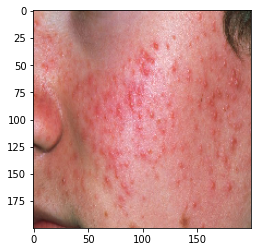

Prediction: fungal acne


In [15]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('acne1.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('acne1.jpg', grayscale=False, target_size=(200, 200))
skindisease_types=skinDiseaseTypes

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = mobile_net_model.predict(x)
print(custom[0])


x = np.array(x, 'float32')


#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skindisease_types[ind])

In [16]:
dataDir = "/content/drive/My Drive/Created Dataset"
acneSeverityLevel= [ item for item in os.listdir(dataDir) if os.path.isdir(os.path.join(dataDir, item)) ]
severeTrainDir = os.path.join(dataDir)

In [17]:
train_data = []
for severity_id, sp in enumerate(acneSeverityLevel):
    for file in os.listdir(os.path.join(severeTrainDir, sp)):
        train_data.append(['{}/{}'.format(sp, file), severity_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'severity_id','Severity Level'])
train.tail()

,File,severity_id,Severity Level
994,Level_1/levle1_568.jpg,2,Level_1
995,Level_1/levle1_583.jpg,2,Level_1
996,Level_1/levle1_36.jpg,2,Level_1
997,Level_1/levle1_383.jpg,2,Level_1
998,Level_1/levle1_479.jpg,2,Level_1


In [18]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.tail()

,File,severity_id,Severity Level
994,Level_0/levle0_308.jpg,0,Level_0
995,Level_0/levle0_417.jpg,0,Level_0
996,Level_1/levle1_397.jpg,2,Level_1
997,Level_2/levle2_179.jpg,1,Level_2
998,Level_0/levle0_263.jpg,0,Level_0


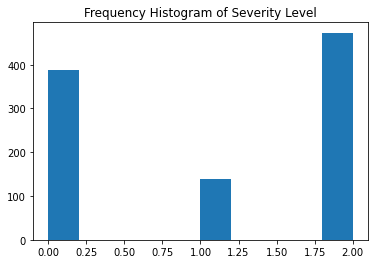

<Figure size 864x864 with 0 Axes>

In [19]:
plt.hist(train['severity_id'])
plt.title('Frequency Histogram of Severity Level')
plt.figure(figsize=(12, 12))
plt.show()

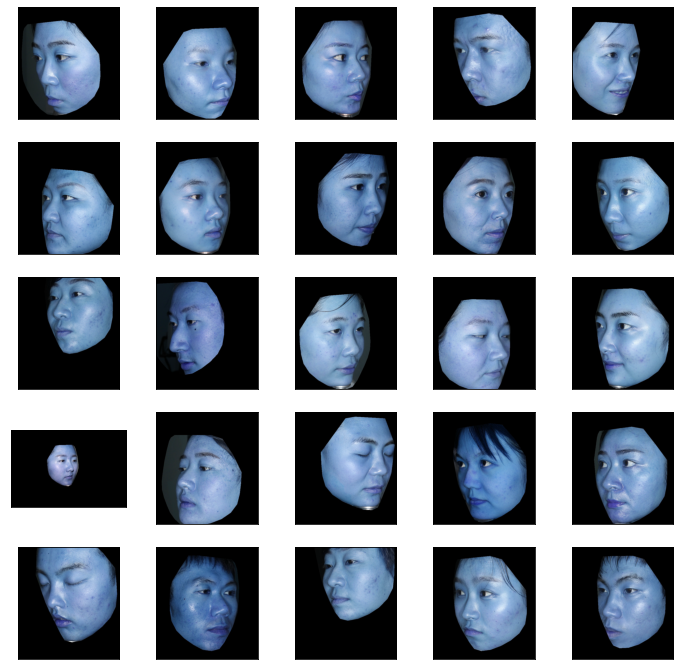

In [20]:
def plot_defects(acneSeverityLevel, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    flower_files = train['File'][train['Severity Level'] == acneSeverityLevel].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(dataDir, flower_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Level_0', 5, 5)

In [21]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(dataDir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [22]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255
print('Train Shape: {}'.format(X_Train.shape))

999it [08:56,  1.86it/s]

Train Shape: (999, 64, 64, 3)


In [23]:
Y_train = train['severity_id'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [24]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)
print(len(X_train))
print(len(Y_train))
print(len(X_val))
print(len(Y_val))

799
799
200
200


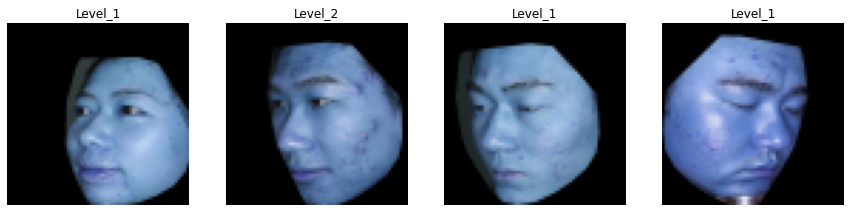

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(acneSeverityLevel[np.argmax(Y_train[i])])

# Mobile Net Model For Acne Severity Model 

In [26]:
import tensorflow as tf
from keras.layers import Dense
from keras import Sequential
from keras.applications import mobilenet


severityModel = Sequential()
severityModel.add(mobilenet.MobileNet(include_top=False, pooling='avg', weights='imagenet'))
severityModel.add(Dense(3, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
severityModel.layers[0].trainable = False

severityModel.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
histtSeverity=severityModel.fit(X_train, Y_train, batch_size= 64, epochs=20, validation_split=0.1)

Epoch 1/20
12/12 [==============================] - 5s 282ms/step - loss: 2.7877 - accuracy: 0.3841 - val_loss: 2.1532 - val_accuracy: 0.5000
Epoch 2/20
12/12 [==============================] - 3s 233ms/step - loss: 2.5990 - accuracy: 0.4570 - val_loss: 1.8446 - val_accuracy: 0.4875
Epoch 3/20
12/12 [==============================] - 3s 232ms/step - loss: 2.8514 - accuracy: 0.4367 - val_loss: 2.2311 - val_accuracy: 0.4000
Epoch 4/20
12/12 [==============================] - 3s 232ms/step - loss: 2.7929 - accuracy: 0.4257 - val_loss: 2.5467 - val_accuracy: 0.4125
Epoch 5/20
12/12 [==============================] - 3s 232ms/step - loss: 2.0983 - accuracy: 0.4822 - val_loss: 2.1501 - val_accuracy: 0.4625
Epoch 6/20
12/12 [==============================] - 3s 232ms/step - loss: 2.2419 - accuracy: 0.4660 - val_loss: 2.0008 - val_accuracy: 0.3000
Epoch 7/20
12/12 [==============================] - 3s 231ms/step - loss: 2.6553 - accuracy: 0.4187 - val_loss: 1.2357 - val_accuracy: 0.4125
Epoch 

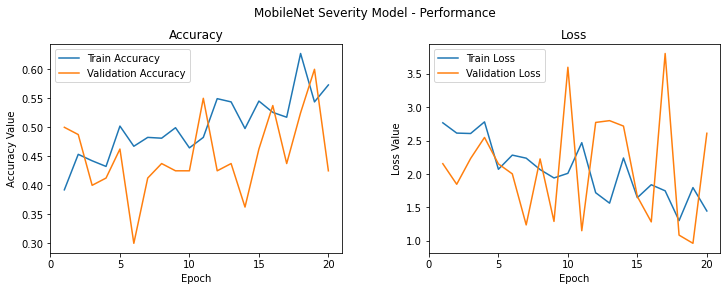

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MobileNet Severity Model - Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, histtSeverity.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, histtSeverity.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, histtSeverity.history['loss'], label='Train Loss')
ax2.plot(epoch_list, histtSeverity.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Testing Acne Severity Model

[0.36949676 0.3443607  0.28614247]


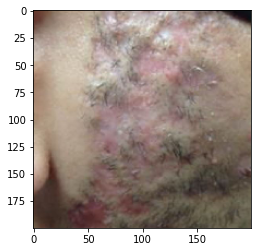

Prediction: Level_0


In [28]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/drive/My Drive/skin-90/Training/Acne/f18.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/My Drive/skin-90/Training/Acne/f18.JPG', grayscale=False, target_size=(200, 200))
skindisease_types=acneSeverityLevel

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = severityModel.predict(x)
print(custom[0])


x = np.array(x, 'float32')


#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',skindisease_types[ind])

In [32]:
mobile_net_model.save("DiseaseDetectionModel.h5")

In [31]:
severityModel.save("SeverityModel.h5")